# Preparations

## Running on colab
You can use this [link](https://colab.research.google.com/github/NBISweden/workshop-neural-nets-and-deep-learning/blob/rnn_labs/session_recurrentNeuralNetworks/lab_airplane_rnn/airplanes.ipynb) to run the notebook on Google Colab. If you do so, it's advised that you first make a copy to your own Google Drive before starting your work on the notebook. Otherwise changes you make to the notebook will not be saved.

## Configuration

Execute the following code blocks to configure the session and import relevant modules.

In [1]:
%config InlineBackend.figure_format ='retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2024-05-22 13:38:31.121696: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 13:38:31.147198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 13:38:31.147214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 13:38:31.147839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 13:38:31.152121: I tensorflow/core/platform/cpu_feature_guar

## Utility functions


In order to save time, here are some utility functions that will be used further down to deal with partitioning of data and plotting history and loss functions. Execute the code blocks to make the functions accessible.



`make_xy` creates `X`, `Y` data pairs from a dataset vector to be used for testing and training, as well as the vector indices relative to the input data. The indices correspond to months and are used for plotting purposes.

In [3]:
def make_xy(data, window_size=1, step_size=1):
    """Create X, Y data pairs from a dataset vector.

    Args:
      data (float, int): dataset vector
      window_size (int): window size; number of dataset points looking back
      step_size (int): step size between windows

    Returns:
      (X, Y, X_indices, Y_indices): 4-tuple consisting of X and Y data vectors and indices 
         of data points (needed for plotting).
    """
    X_indices = []
    X = []
    Y_indices = np.arange(window_size, len(data), step_size)
    Y = data[Y_indices]
    j = 0
    for i, _ in enumerate(Y_indices):
        ind = list(range(j, j + window_size))
        j = j + step_size
        X_indices.append(ind)
        X.append(data[ind])
    X = np.reshape(np.array(X), (len(Y), window_size, 1))
    return X, Y, np.array(X_indices), Y_indices

`plot_pred` plots the original data along with prediction.

In [4]:
def plot_pred(data, scaler=None, rmse=True, plotmarkers=False, show=True, **kw):
    """Plot prediction and original data

    Args:
      data (dict): dictionary where each key points to a 3-tuple consisting of 
        prediction, original data, and indices of prediction relative to original data
      scaler (Scaler): Scaler object to inverse transform data to original scale or None
      rmse (bool): include RMSE
      plotmarkers (bool): add markers to line plots for clarity
      show (bool): show plot
      kw (dict): keyword args passed to plt.subplots

    Returns:
      None
    """
    ticks = kw.pop("ticks", None)
    labels = kw.pop("labels", None)
    fig, ax = plt.subplots(**kw)
    legend = []
    markers = ["*", "x", "o"]
    colors = ["black", "steelblue", "darkred", "green"]
    x = []
    y = []
    shift = 0
    for k, v in data.items():
        if v is None:
            continue
        Ypred, Y, Y_indices = v
        X = np.arange(len(Y)) + shift
        shift = shift + len(X)
        if scaler is not None:
            Y = scaler.inverse_transform(Y.reshape(-1, 1)).flatten()
            Ypred = scaler.inverse_transform(Ypred.reshape(-1, 1)).flatten()
        e = math.sqrt(mean_squared_error(Y[Y_indices], Ypred))
        if rmse:
            k = f"{k} (RMSE: {e:.4f})"
        legend.append(k)
        col = colors.pop()
        ax.plot(X[Y_indices], Ypred, color=col)
        if plotmarkers:
            ax.plot(X[Y_indices], Ypred, markers.pop(), color=col)
        x.extend(X)
        y.extend(Y)
    legend.append("Data")
    ax.plot(x, y, "-", color=colors.pop())
    ax.set_title("Model prediction")
    if ticks is not None and labels is not None:
        ax.set_xticks(ticks, labels=labels)
    ax.legend(legend)
    if show:
        plt.show()

`plot_loss_acc` plots loss and accuracy of history.

In [5]:
def plot_loss_acc(history):
    """Plot loss and accuracy of history

    Args:
      history (keras.src.callbacks.History): model history
    """
    try:
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
    except KeyError:
        plt.plot(history.history["acc"])
        plt.plot(history.history["val_acc"])

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train acc", "val acc", "train loss", "val loss"], loc="upper left")
    plt.show()

`plot_history` plots the training and/or test accuracy or loss values.

In [6]:
def plot_history(history, show=True, xlim=None, ylim=None, **kw):
    """Plot history - plot training and/or test accuracy or loss values
    
    Args:
      history (keras.src.callbacks.History): model history
      show (bool): show plot
      xlim (tuple): tuple of min, max x values
      ylim (tuple): tuple of min, max y values
      kw (dict): keyword args passed to plt.subplots
      
    """
    datalabels = ["Training", "Validation"]
    metrics_labels = {
        "loss": "loss",
        "acc": "accuracy",
        "accuracy": "accuracy",
        "mse": "mse",
        "recall": "recall",
    }
    if not isinstance(history, dict):
        history = history.history
    hkeys = history.keys()
    h = np.array([history[k] for k in hkeys])
    labels = [
        f"{x} {y}"
        for x, y in zip(
            [datalabels[u.startswith("val_")] for u in hkeys],
            [metrics_labels[v.replace("val_", "")] for v in hkeys],
        )
    ]
    fig, ax = plt.subplots(**kw)
    ax.plot(np.array(range(0, h.shape[1])), h.T)
    ax.set_title("Model metrics")
    ax.set_ylabel("Metric")
    ax.set_xlabel("Epoch")
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend(list(labels), loc="upper left")
    if show:
        plt.show()

Finally, `make_train_test` splits data input into a train and test dataset. The function is actually not used below; rather, each step of the function is included as an explicit step. Nevertheless, we show the function here for reference as it was mentioned in the lecture.

In [7]:
def make_train_test(data, train_fraction=0.67, rescale=True):
    """Create train and test data set from a data vector.

    Args:
      data (np.array): data array
      train_fraction (float): fraction of data devoted to training
      rescale (bool): rescale data to range 0, 1, else use min-max range of data

    Returns:
      (train, test, data): 3-tuple of train, test, and original data
    """
    split = int(len(data) * train_fraction)
    if rescale:
        scaler = MinMaxScaler(feature_range=(0, 1))
    else:
        scaler = MinMaxScaler(feature_range=(min(data), max(data)))
    data = scaler.fit_transform(data).flatten()
    train = data[range(split)]
    test = data[split:]
    return train, test, scaler

# Lab session: predicting airline passengers

## Aims

In this lab the idea is to try out different RNN models on the Box & Jenkins monthly airline passengers dataset. The dataset is a monthly time series of airline passengers recorded in the 50'ies and 60'ies. Your task is to build a model to make a future prediction of the number of passengers given a number of observation.

You will download data and prepare it for later analyses. More specifically, you will partition the data into a training and test set. In order to create input / label pairs (X/Y), the data is split into time slices, where a slice corresponds to the input (X) and the consecutive time point the (known) output (Y).


To help you along the way, some of the steps have been prepared in advance, but in most cases, your task is to complete missing code. Don't hesitate to change parameter settings and experiment with the model architectures. Also, make sure to examine the contents of variables by printing them. Things to try:

- change the number of time steps
- change the number of epoch
- experiment with the network topology (e.g. number of units in the hidden layer)

See if you can improve on the model presented in the lecture.

# Session 1: Vanilla RNN

## Download data

Start by downloading the data and loading it into a pandas dataframe:

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv --no-check-certificate

We modify the data somewhat for easier processing. `df.head()` simply shows you the first entries of the data frame.

In [8]:
df = pd.read_csv('airline-passengers.csv')
df = df.rename(columns={'Month': 'time','Passengers': 'passengers'})
df['time'] = pd.to_datetime(df['time'], format='%Y-%m')
df['year'] = pd.DatetimeIndex(df['time']).year
df['month'] = pd.DatetimeIndex(df['time']).month
df.head()

,time,passengers,year,month
0,1949-01-01,112,1949,1
1,1949-02-01,118,1949,2
2,1949-03-01,132,1949,3
3,1949-04-01,129,1949,4
4,1949-05-01,121,1949,5


Plot the data for overview:

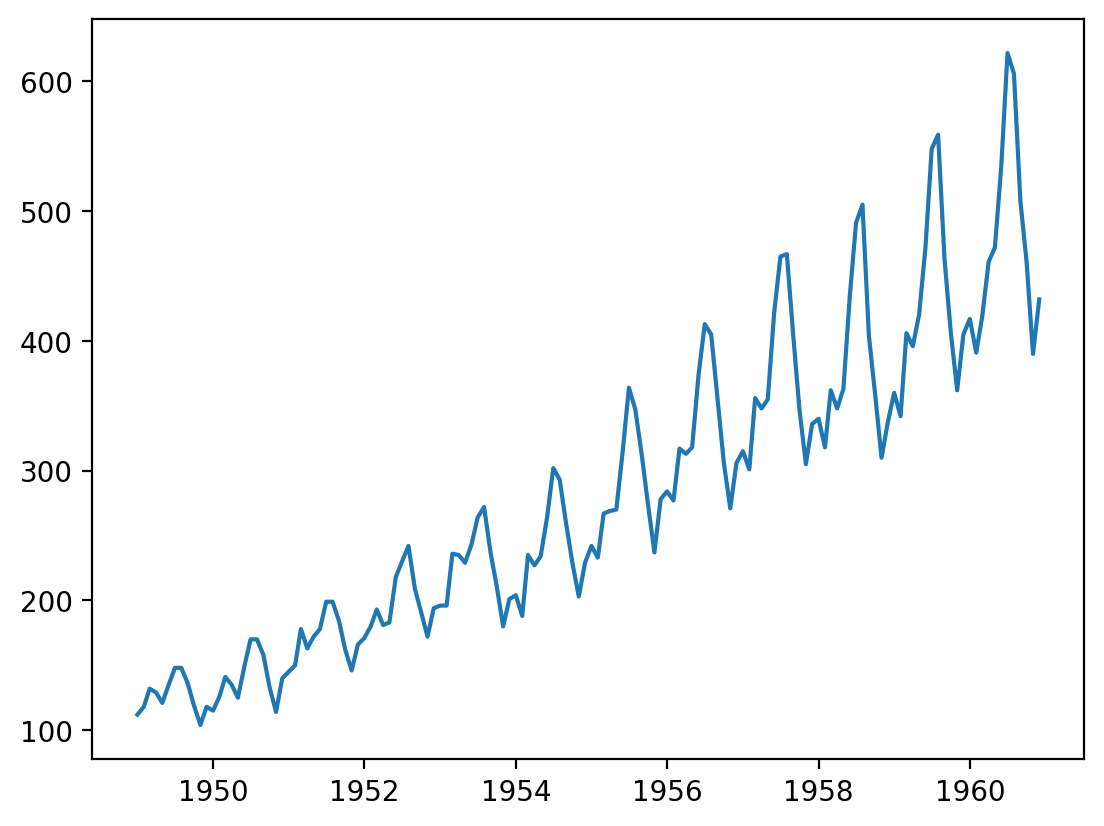

In [9]:
plt.plot(df.time, df.passengers)

## Create training and test data


Next, we partition the data into training and test data sets. We first define the size of the training set and the index at which to split the data.

In [10]:
train_fraction = 0.7
split_index = int(df.shape[0] * train_fraction)

The [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) function rescales (normalizes) the data to values in the range (0, 1) without distorting the shape of the input distribution. Many machine learning algorithms work better when features are on similar scales.

Here, it is important to remember that scaling should be done first on the training data, and then that the same transformation is applied to the test data. In practice, we first rescale the training data independently. Then, the resulting scaler instance is used to rescale both the test data and the entire data set.

In [11]:
# Reshape data for MinMaxScaler
data = np.array(df['passengers'].values.astype('float32')).reshape(-1, 1)
# Instantiate scaler object
scaler = MinMaxScaler(feature_range=(0, 1))
# Scale training data
train = data[range(split_index)]
train_scaled = scaler.fit_transform(train).flatten()
# Apply *same* transformation to test data
test = data[split_index:]
test_scaled = scaler.transform(test).flatten()

Plot the datasets to visualize the split. Notice in particular the magnitude of the y-values for both datasets.


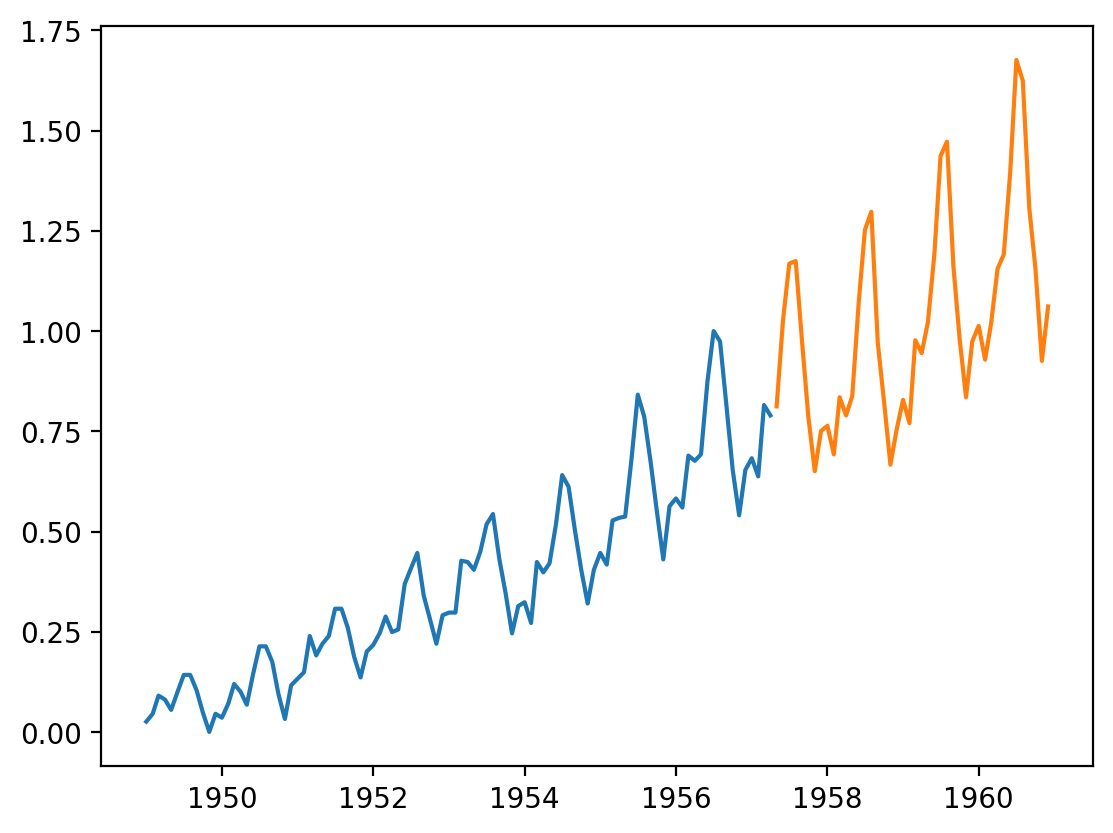

In [12]:
plt.plot(df.time[:split_index], train_scaled), plt.plot(df.time[split_index:], test_scaled);

## Transform data to input - output pairs


Now that we have train and test data sets we need to convert the data to input - output (X/Y) pairs. The general idea is to take time slices (e.g. 12 data points) as input vectors and use the subsequent value as the known output. Since the time unit is months and there likely is a recurrent yearly seasonality in the data it makes sense to use 12 time steps, but this is a parameter you could modify to see what effect it has on the end results. In particular, if you increase this number, you would look further back in the past when making predictions.

In [13]:
time_steps = 12
trainX, trainY, trainX_indices, trainY_indices = make_xy(train_scaled, window_size=time_steps)
testX, testY, testX_indices, testY_indices = make_xy(test_scaled, window_size=time_steps)

## Define the model


Complete the model below to include a [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/) layer and a [Dense](https://keras.io/api/layers/core_layers/dense/) output layer. If you look at the SimpleRNN documentation, you will find that `inputs` is a 3D tensor (`[batch, timesteps, feature]`). Since we are using univariate data (i.e. one feature, namely the number of passengers, per time step), `features=1`. Recall also that for the `input_shape` parameter you don't specify `batch`. Consult the documentation or lecture notes for more information. There is a worked example [airplanes-worked.ipynb](airplanes-worked.ipynb) that you can consult if you get stuck, but first try to complete the model without peeking!

In [ ]:
# model = Sequential()
# Add layers here
# model.add()
#
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [25]:
model = Sequential()
model.add(SimpleRNN(units=20, input_shape=(time_steps, 1), activation="tanh", return_sequences=False))
model.add(Dense(units=8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 20)                440       
                                                                 
 dense_4 (Dense)             (None, 8)                 168       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 617 (2.41 KB)
Trainable params: 617 (2.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Once you are happy with the configuration, fit the model and evaluate. 

In [ ]:
# history = model.fit(trainX, trainY, ...)
# Ytrainpred = model.predict(trainX)
# Ytestpred = model.predict(testX)

In [26]:
history = model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=0)
Ytrainpred = model.predict(trainX)
Ytestpred = model.predict(testX)

1/1 [==============================] - 0s 13ms/step


You can use the utility plotting functions to plot training history and predictions

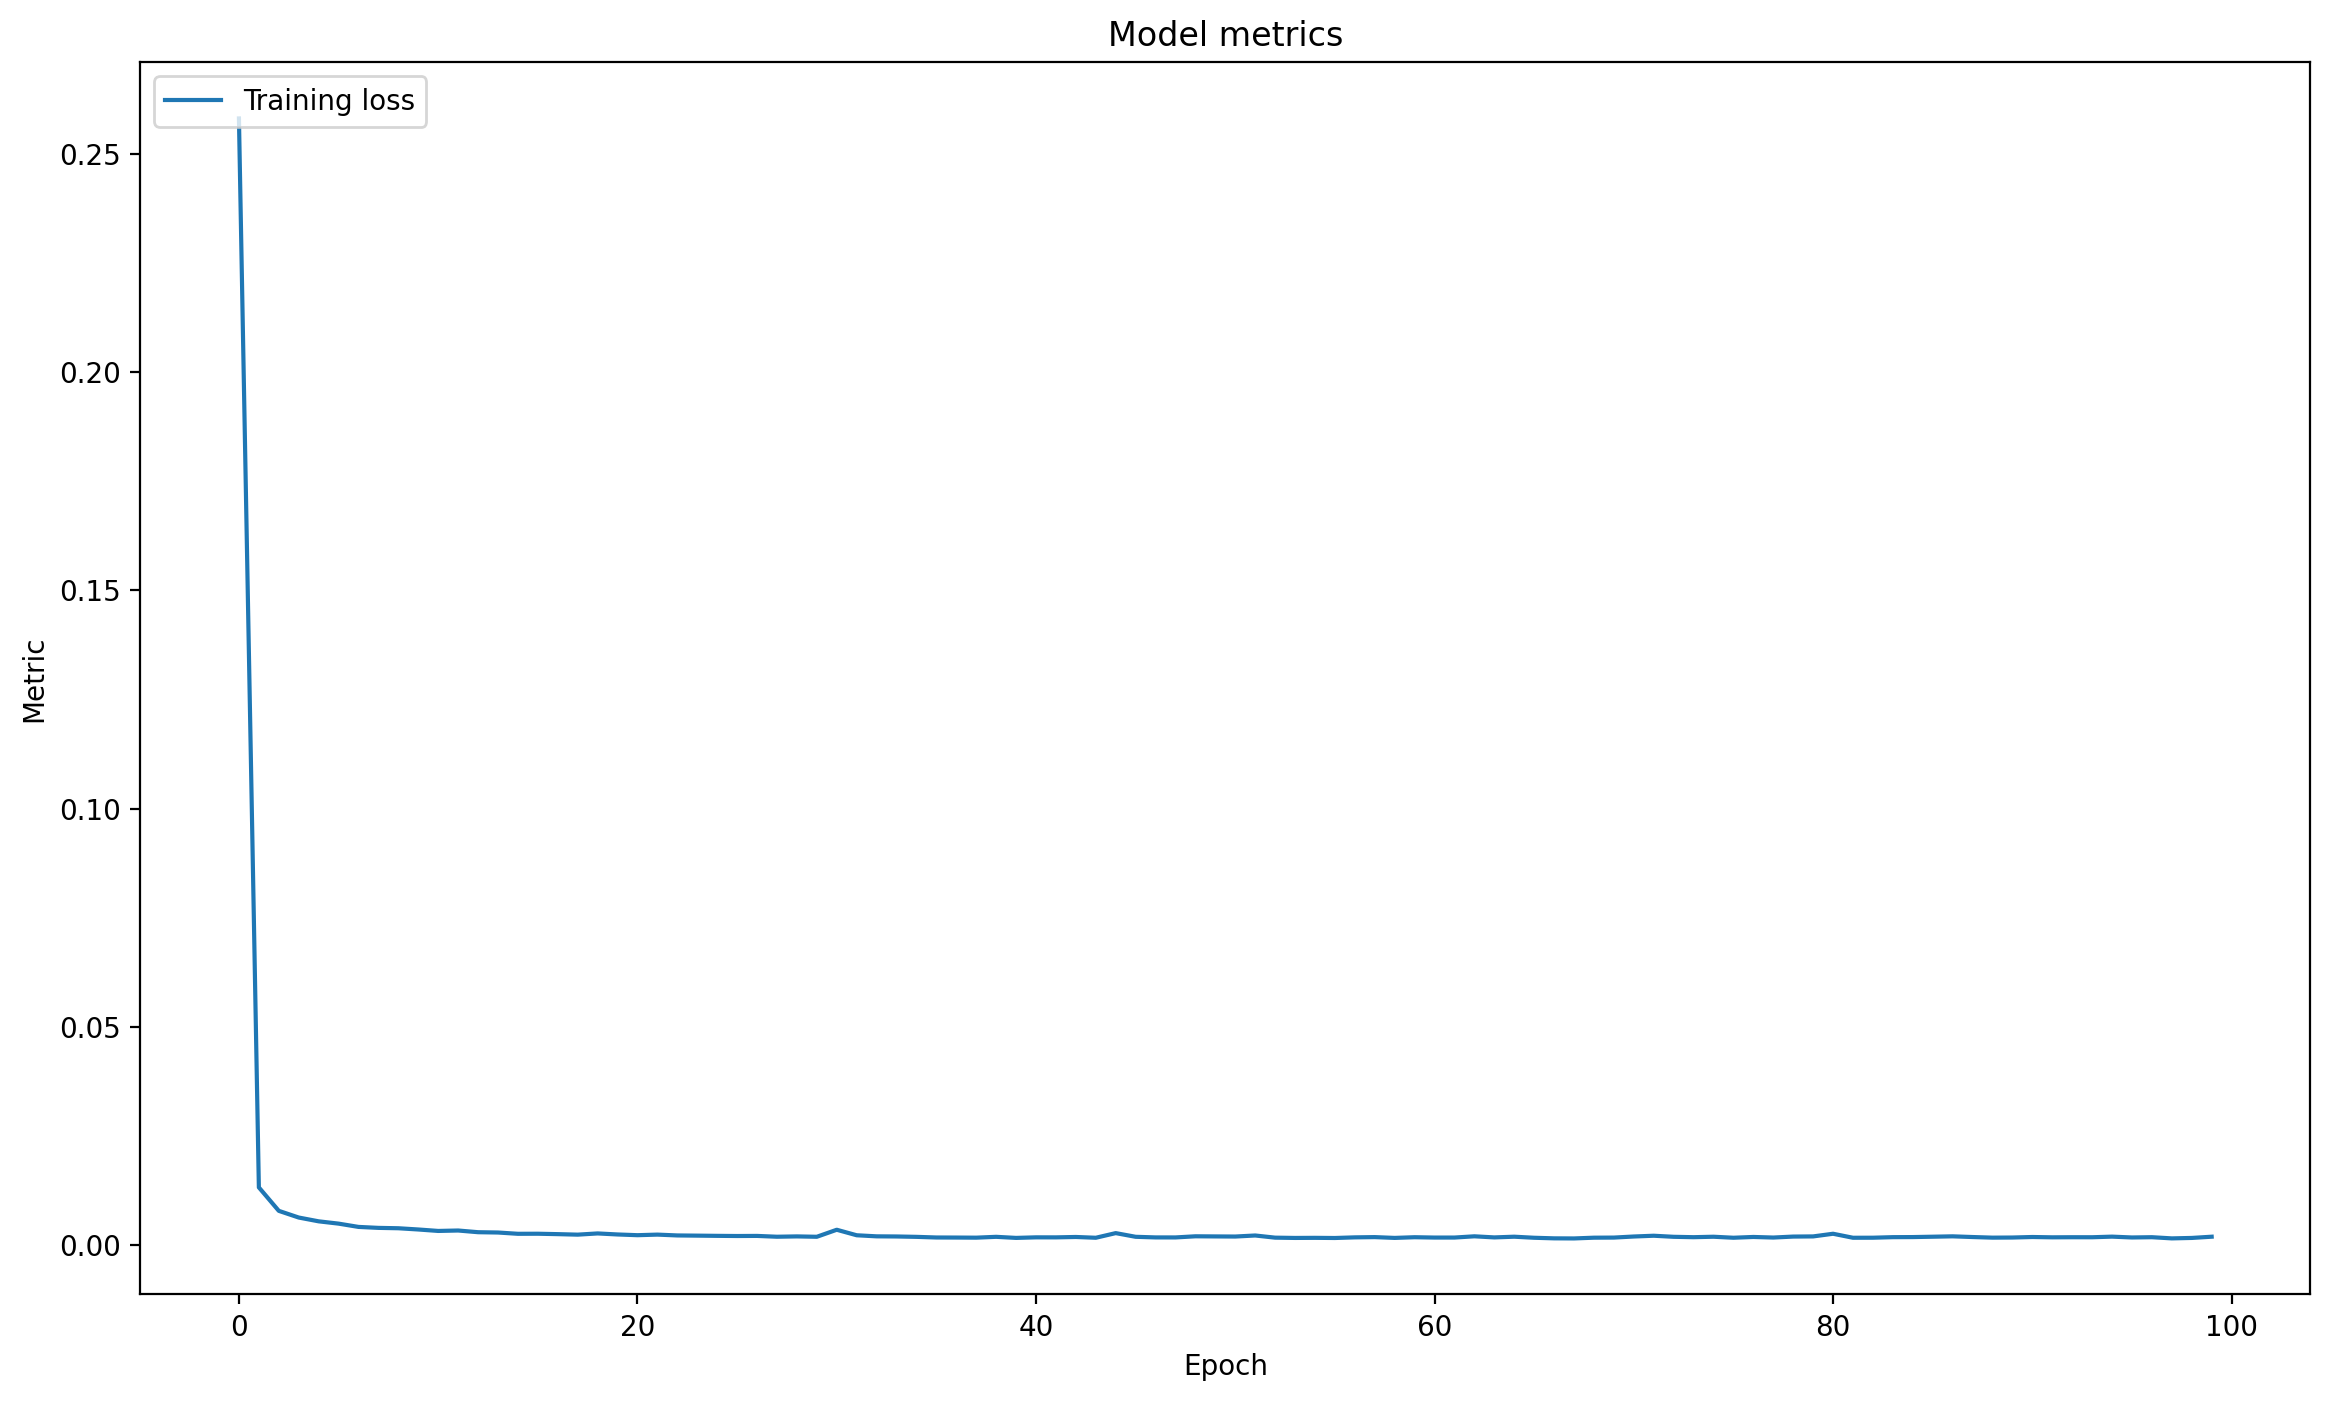

In [27]:
plot_history(history, figsize=(14, 8))

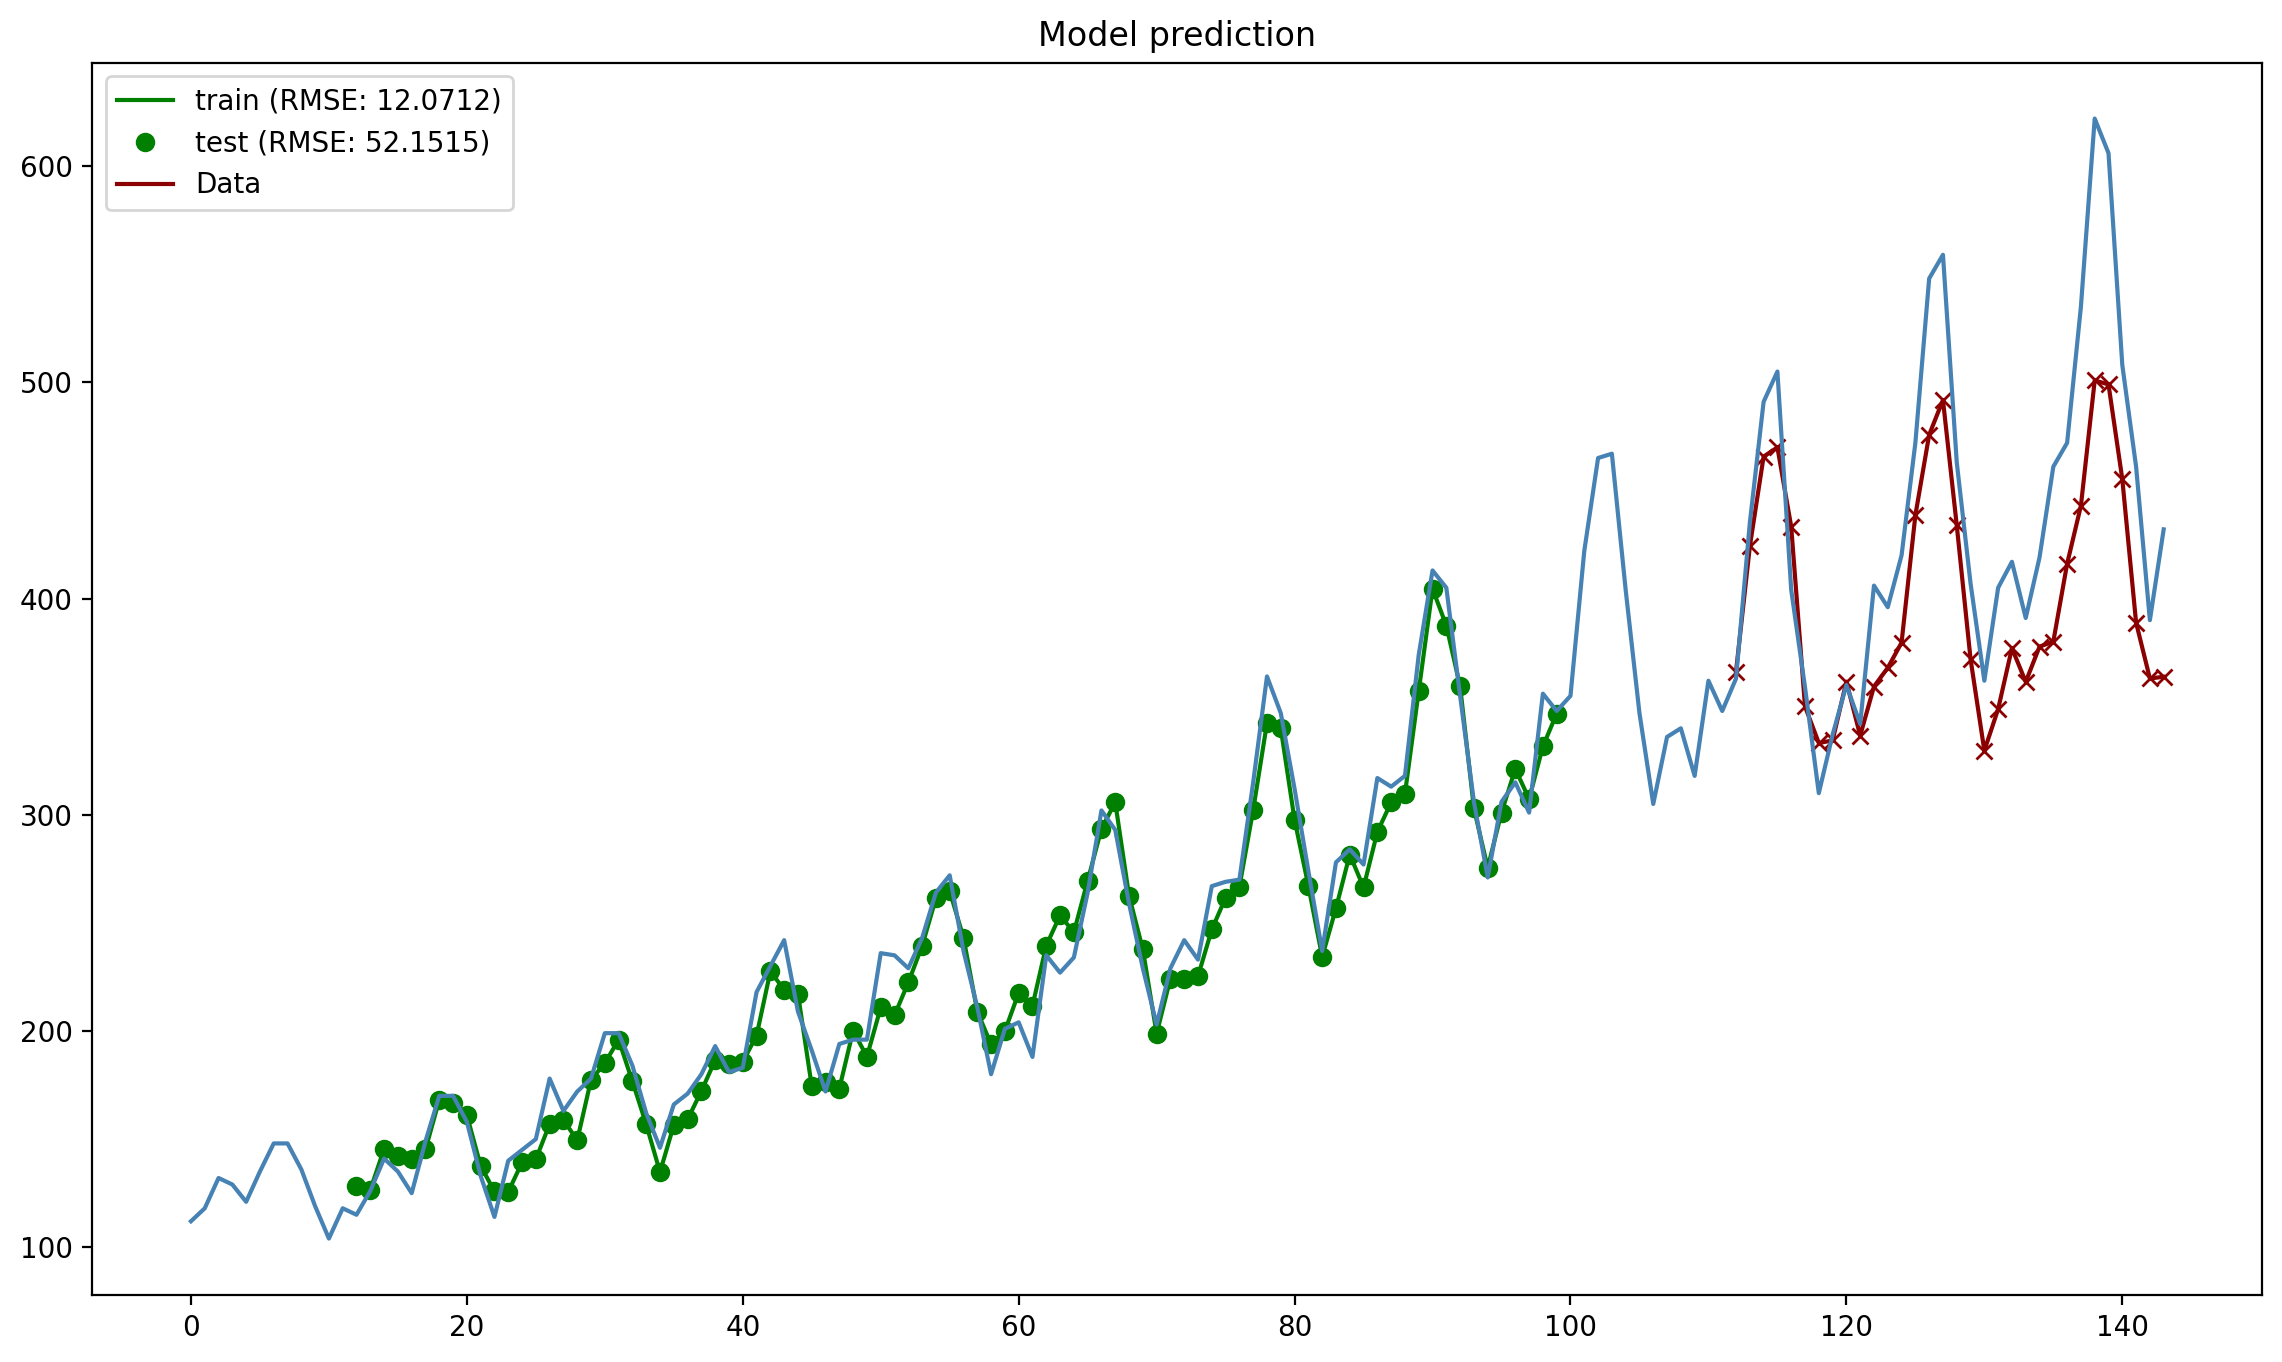

In [28]:
data = {'train': (Ytrainpred, train_scaled, trainY_indices),
       'test': (Ytestpred, test_scaled, testY_indices)}
plot_pred(data, scaler=scaler, figsize=(14, 8), plotmarkers=True)







# Session 2: LSTM (and optionally GRU) 

Building on session 1, analyse the data set using LSTM layers. Here is a tentative model setup to get you started. Here you could try using multiple layers, in which case you need to return the sequences for all but the last layer (cf [Stacked Long Short-Term Memory Networks](https://machinelearningmastery.com/stacked-long-short-term-memory-networks/)). If you have time, you can also try out the GRU layers for comparison. Do you notice any difference?

In [ ]:
# model = Sequential()
# Remember: if you stack LSTMs, remember to set return_sequences=True for all but the last layer
# model.add(LSTM(..., return_sequences=True, input_shape=(..., ...)))
# model.add(LSTM(..., return_sequences=False))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.summary()

In [29]:
time_steps = 18
trainX, trainY, trainX_indices, trainY_indices = make_xy(train_scaled, window_size=time_steps)
testX, testY, testX_indices, testY_indices = make_xy(test_scaled, window_size=time_steps)

In [30]:
model = Sequential()
model.add(LSTM(units=8, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 945 (3.69 KB)
Trainable params: 945 (3.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Once you're satisfied, fit the model and plot history and prediction.

In [34]:
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0, validation_split=0.1)
Ytrainpred = model.predict(trainX)
Ytestpred = model.predict(testX)

1/1 [==============================] - 0s 13ms/step


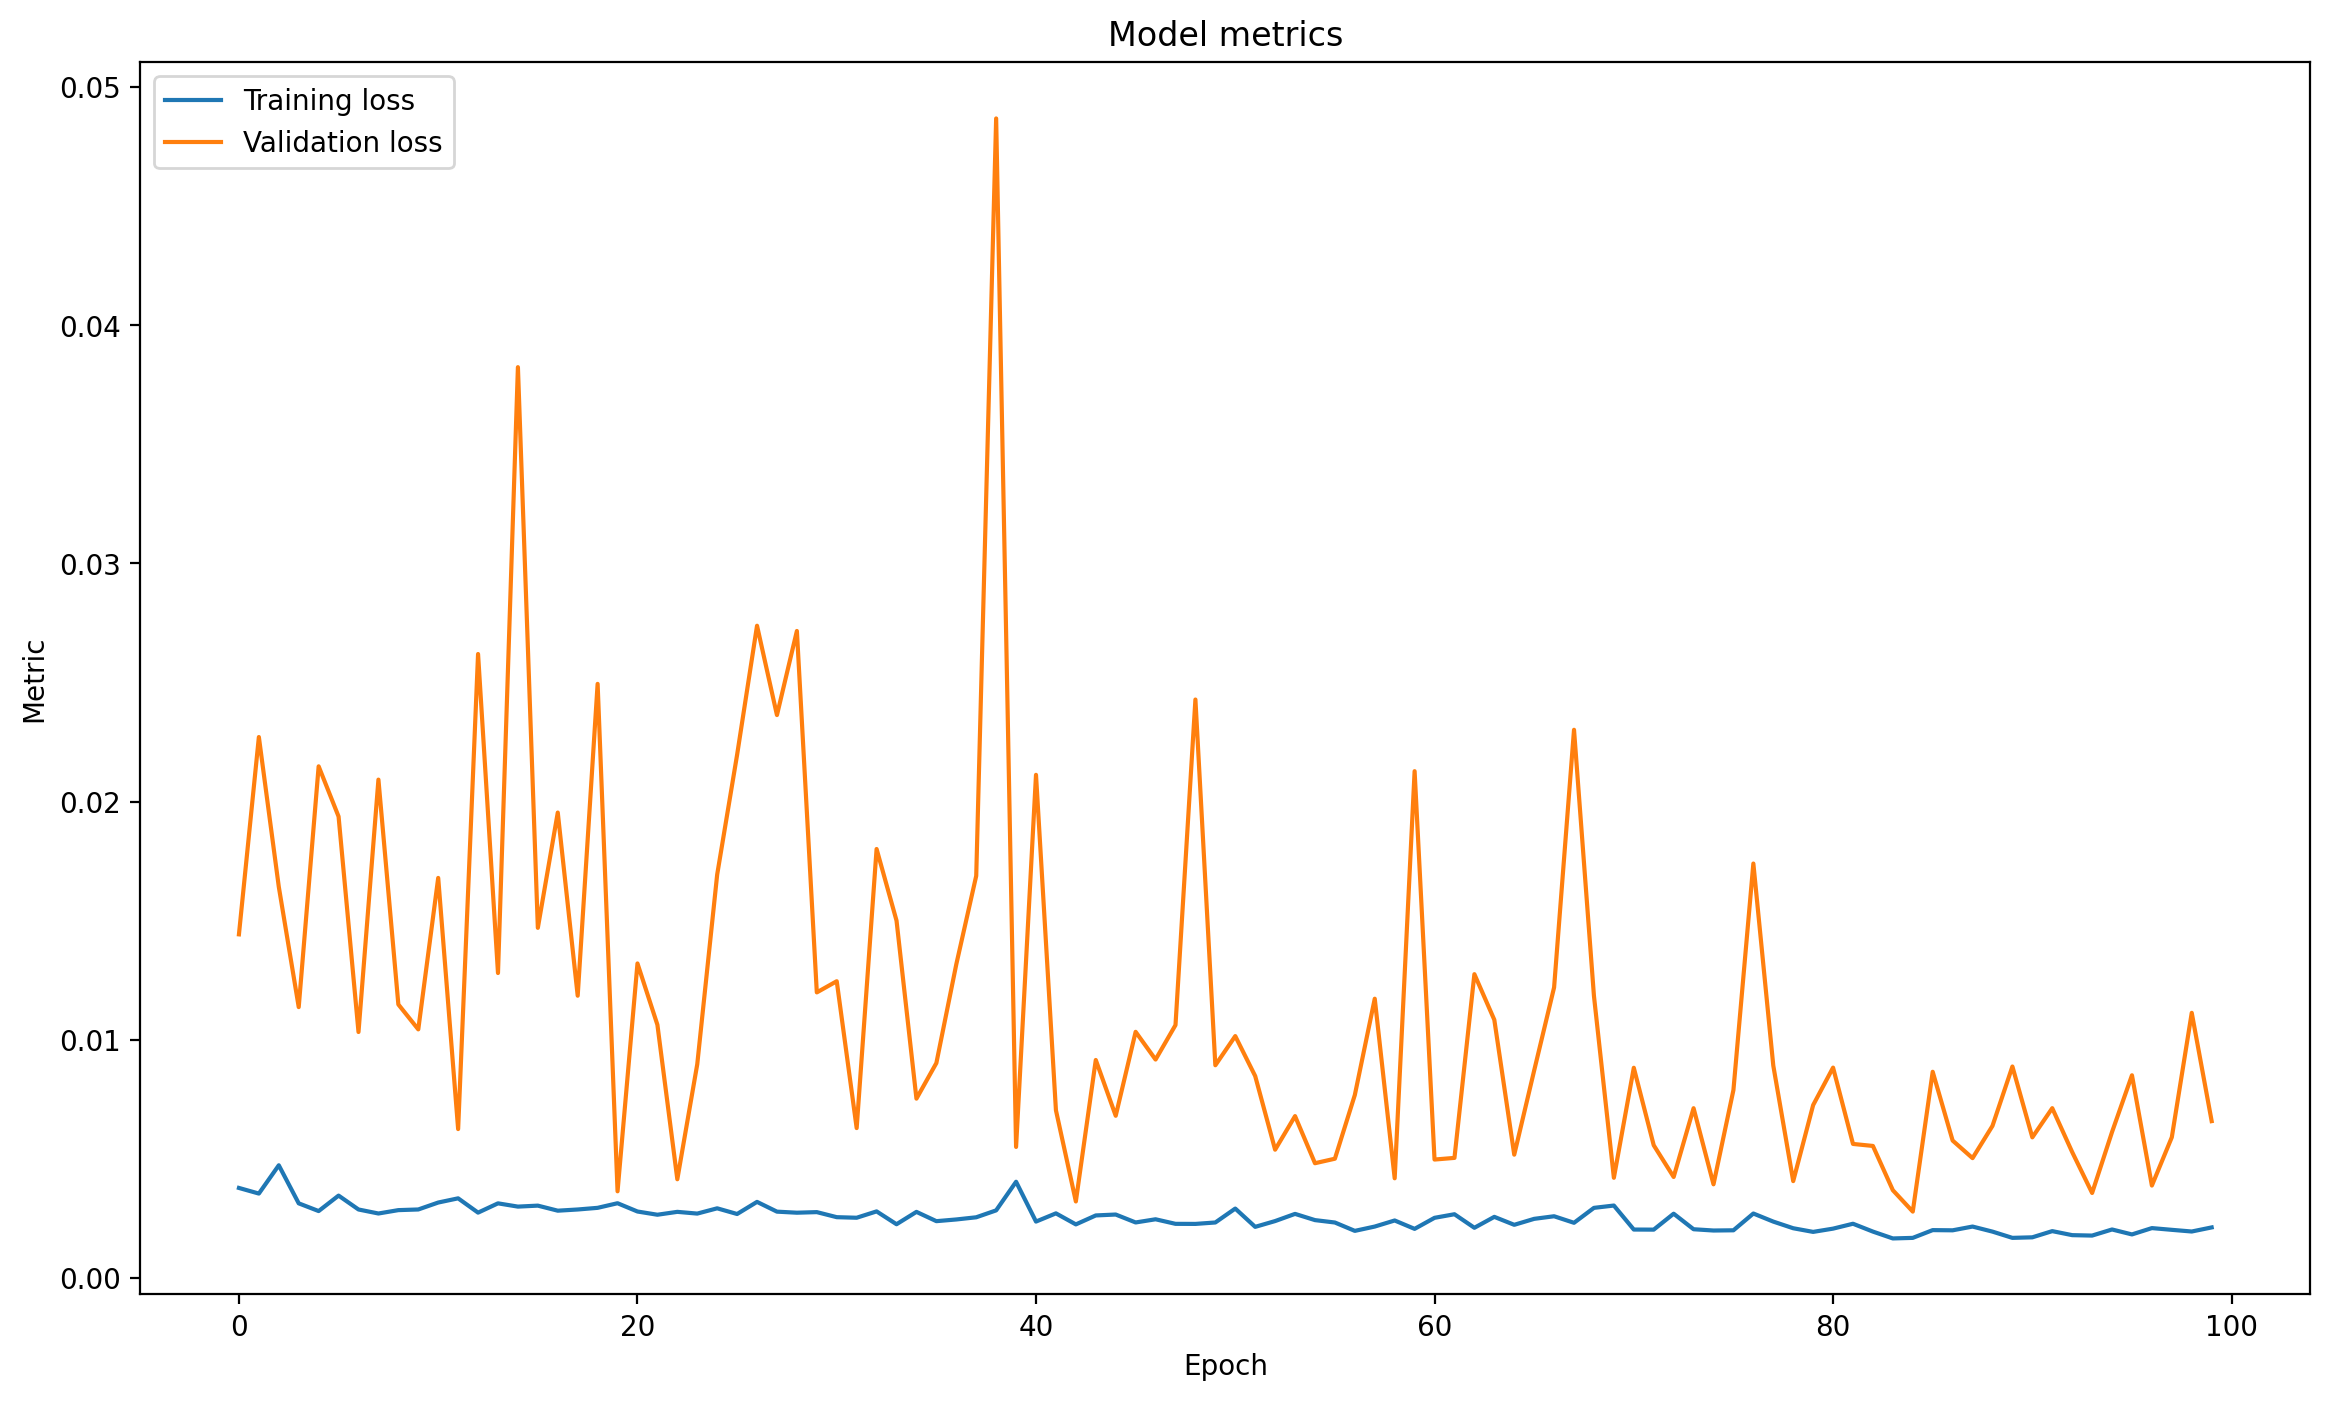

In [35]:
plot_history(history, figsize=(14, 8))

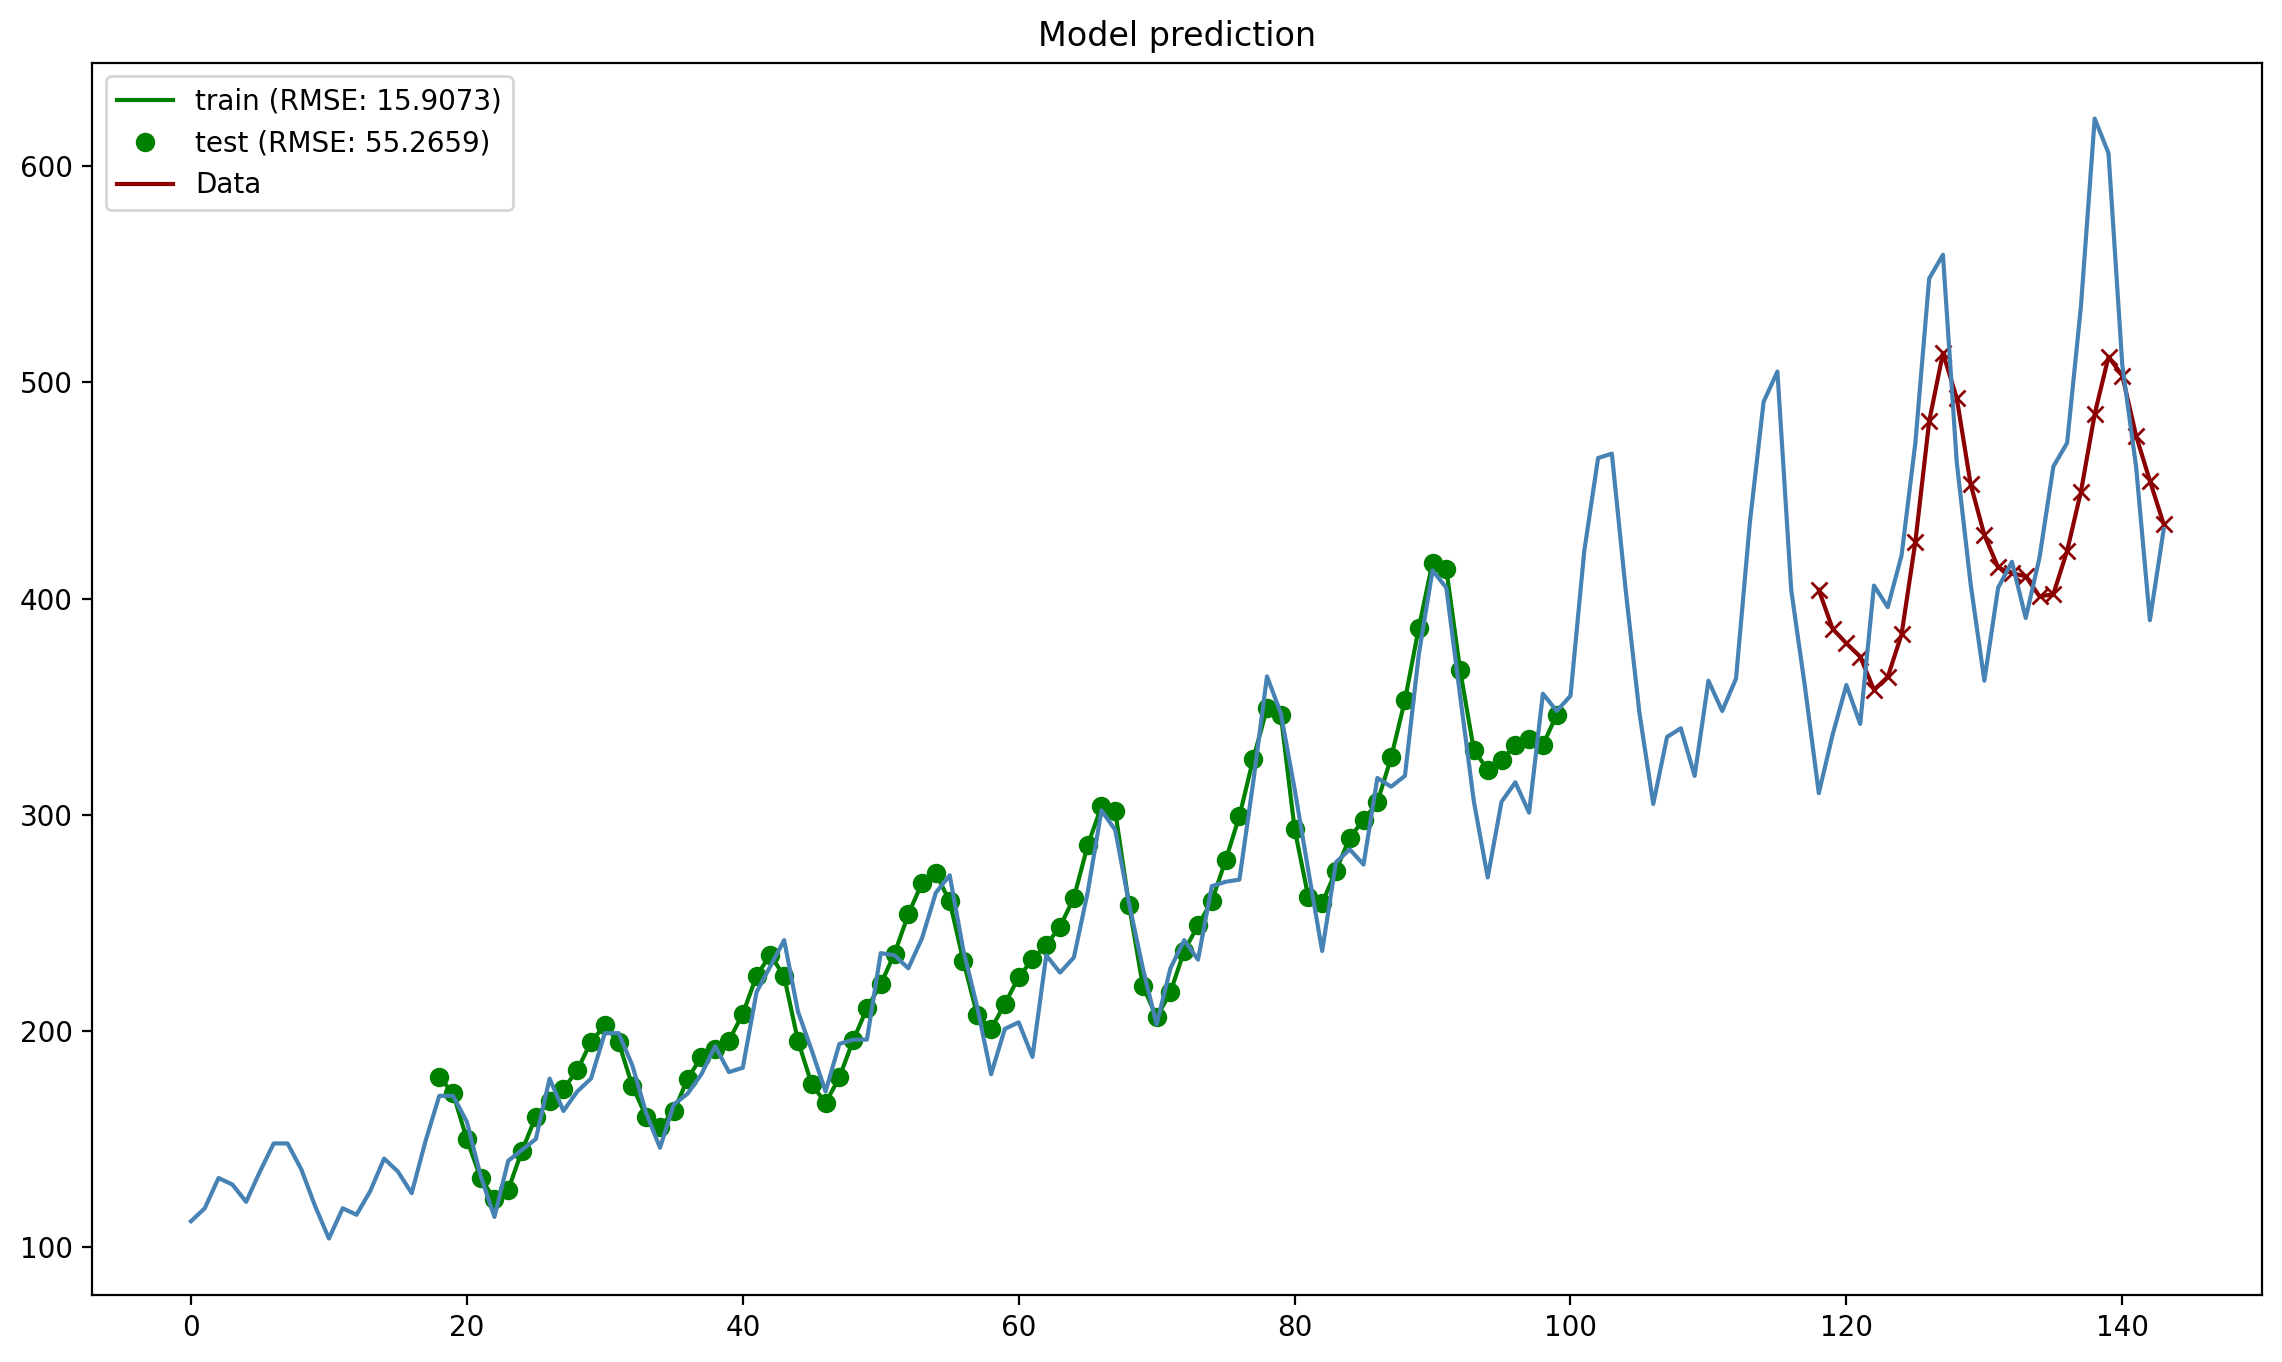

In [36]:
data = {'train': (Ytrainpred, train_scaled, trainY_indices),
       'test': (Ytestpred, test_scaled, testY_indices)}
plot_pred(data, scaler=scaler, figsize=(14, 8), plotmarkers=True)

Recall that the default setting for time steps is 12. If you increase this number, you would look further back in time, which in principle should play to the strength of LSTMs. Note that this need not necessarily lead to better predictions though.

# Resources

The airplanes dataset is a commonly used example to introduce time series forecasting with Recurrent Neural Networks, and there are numerous blog posts on the topic. There is also a library called [Darts](https://unit8co.github.io/darts/index.html) that is dedicated to time series analyses in Python. On the Darts website you can find a [worked example](https://unit8co.github.io/darts/examples/04-RNN-examples.html) that highlights some additional aspects of time series forecasting, such as making use of the known covariates month and year.